# CLEANING DATASET

Dataset has the below columns:
- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint


In [1]:
pip install imbalanced-learn scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade imbalanced-learn


Requirement already up-to-date: imbalanced-learn in c:\users\admin\anaconda3\envs\learn-env\lib\site-packages (0.12.4)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing libraries
# Data manipulation and exploration
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Feature selection and engineering
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

#Model evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

## Reading Dataset

### 1.0 Loading and insecting data

In [4]:
# Function for loading and inspecting dataset
def load_and_inspect_data(file_path):
   
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Display dataset structure
    print("First 5 rows of the dataset:")
    print(df.head(), "\n")
    
    print("Dataset information:")
    print(df.info(), "\n")
    
    print("Summary statistics for numerical features:")
    print(df.describe(), "\n")
    
    print("Missing values in each column:")
    print(df.isnull().sum(), "\n")
    
    return df

In [5]:
# File paths for our datasets
train_df_file_path = '../data/Train_set_data.csv'
test_df_file_path = '../data/Test_set_data.csv' # this was the test data dowloaded from the datasite
train_labels_file_path = '../data/Train_set_labels.csv'

# Passing,loading and inspecting function to our datasets
train_df = load_and_inspect_data(train_df_file_path)
test_valid_df = load_and_inspect_data(test_df_file_path) # will use this for validation exercise treat as independent 
train_labels_df = load_and_inspect_data(train_labels_file_path)

First 5 rows of the dataset:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... payment_type  \
0  34.938093  -9.856322                  none            0  ...     annually   
1  34.698766  -2.147466              Zahanati            0  ...    never pay   
2  37.460664  -3.821329           Kwa Mahundi            0  ...   per bucket   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...    never pay   
4  31.130847  -1.825359               Shuleni            0  ...    never pay   

  water_quality quali

In [6]:
# Merge the train_set and train_set_labels on ID
wells_data = pd.merge(train_df,train_labels_df,on='id')

# creating a new train dataset cv 'wells_data'
wells_data.to_csv('../data/wells_data.csv',index=False)
# loading and inspecting our train
wells_data_file_path = '../data/wells_data.csv'
wells_data = load_and_inspect_data(wells_data_file_path)

First 5 rows of the dataset:
      id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group

In [7]:
# Function to convert all categorical rows to uppercase
def convert_categorical_to_uppercase(df):
    # Convert categorical column data to uppercase
    for column in df.select_dtypes(include=['object', 'category']).columns:
        df[column] = df[column].apply(lambda x: x.upper() if isinstance(x, str) else x)

    return df
# converting our rows to upper case
df = wells_data
wells_data = convert_categorical_to_uppercase(df)

In [8]:
def unique_values_for_all_categorical(df):
    
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Initialize list to store rows
    rows = []

    # Loop through each categorical column
    for column in categorical_columns:
        unique_count = df[column].nunique()
        rows.append({'Column': column, 'Unique_count': unique_count})

    # Convert rows to a DataFrame
    result_df = pd.DataFrame(rows)

    return result_df

result_df = unique_values_for_all_categorical(df = wells_data)
result_df


,Column,Unique_count
0,date_recorded,356
1,funder,1897
2,installer,1935
3,wpt_name,37399
4,basin,9
5,subvillage,19287
6,region,21
7,lga,125
8,ward,2092
9,public_meeting,2


### 2.0 Cleaning data 

Missing Values

In [9]:
# Summarize missing values
def analyze_missing_values(df):

    # sums missing values per feature
    missing_values_summary = df.isnull().sum()

    # calculates percentage of missing values
    missing_percentage = (missing_values_summary / len(df)) * 100

    # Creating a DataFrame for better visualization
    missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values_summary,
    'Percentage': missing_percentage}).sort_values(by='Missing Values', ascending=False)

    # Displaying columns with missing values
    print("Missing Data Summary:")
    print(missing_data_summary[missing_data_summary['Missing Values'] > 0])
    return missing_data_summary

# Analyze missing values in train_data
missing_data_summary = analyze_missing_values(wells_data)

Missing Data Summary:
                   Missing Values  Percentage
scheme_name                 28166   47.417508
scheme_management            3877    6.526936
installer                    3655    6.153199
funder                       3635    6.119529
public_meeting               3334    5.612795
permit                       3056    5.144781
subvillage                    371    0.624579


Handling missing values

In [10]:
# Handling  missing data for each columns with missing values

# scheme_name - fill with placeholder as it already has 2696 unique values
wells_data['scheme_name'].fillna('UNKNOWN', inplace=True)

# Fill missing values in 'scheme_management' grouped by 'basin'
wells_data['scheme_management'] = wells_data['scheme_management'].fillna(
    wells_data.groupby('basin')['scheme_management'].transform(lambda x: x.mode().iloc[0])
)

# installer and funder - Fill with placeholder
wells_data['installer'].fillna('UNKNOWN', inplace=True)
wells_data['funder'].fillna('UNKNOWN', inplace=True)

# public_meeting - Fill with mode grouped by basin schememe management
# Calculate the mode for each group in 'scheme_management'
group_modes = wells_data.groupby('scheme_management')['public_meeting'].transform(lambda x: x.mode()[0] if not x.mode().empty else None)

# Fill missing values in 'public_meeting' with the corresponding group mode
wells_data['public_meeting'].fillna(group_modes, inplace=True)

# permit - Fill with mode
# Calculate the mode for each group in 'scheme_management'
group_modes_permit = wells_data.groupby('scheme_management')['permit'].transform(lambda x: x.mode()[0] if not x.mode().empty else None)

# Fill missing values in 'permit' with the corresponding group mode
wells_data['permit'].fillna(group_modes_permit, inplace=True)

# subvillage - Fill with placeholder
wells_data['subvillage'].fillna('UNKNOWN', inplace=True)

# Verifying there are no missing values left
print("Remaining Missing Values:")
print(wells_data.isnull().sum().sum())  # Should return 0

Remaining Missing Values:
0


Understanding data distribution for numerical columns

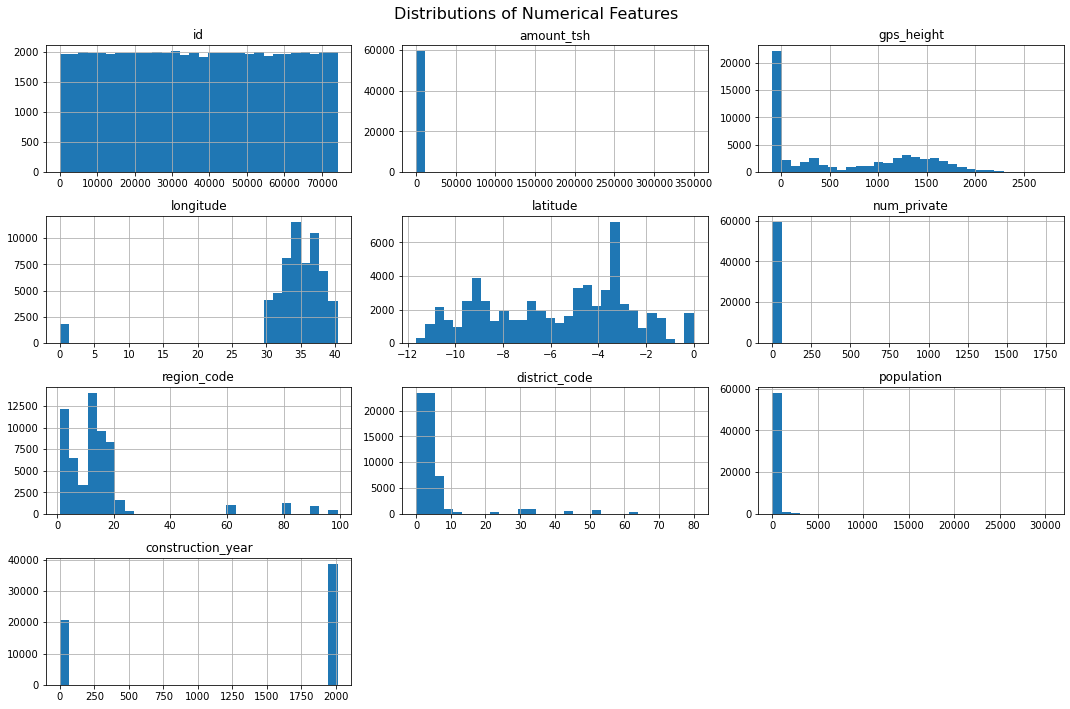

In [11]:
# Numerical column distributions
numerical_cols = wells_data.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for numerical columns
wells_data[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

Checking for numerical columns with 0 as values

In [12]:
#Select numerical columns
numerical_columns = wells_data.select_dtypes(include=['number'])

# Check which columns contain zeros and count the number of zeros
zero_counts = (numerical_columns == 0).sum()

# Filter to display only columns with zeros
columns_with_zeros = zero_counts[zero_counts > 0]

# Display results
print(columns_with_zeros)


id                       1
amount_tsh           41639
gps_height           20438
longitude             1812
num_private          58643
district_code           23
population           21381
construction_year    20709
dtype: int64


- *gps_height, num_private, district_code, population, construction_year should not have 0s*
- *amount_tsh is the only ones that can have zeros as it means the wells are dry

Handling numerical columns with zeros as values

In [13]:
# Handling zeros in the numerical values
def handle_zeros_numericals(df):
    """
    Handles zero values in specific columns of the DataFrame based on their context.
    """
    # Handling gps_height
    df['gps_height'] = df.groupby('region')['gps_height'].transform(
        lambda x: x.replace(0, x.median())
    )

    # Handling longitude
    df['longitude'] = df.groupby('region')['longitude'].transform(
        lambda x: x.replace(0, x.median())
    )

    # Handling num_private
    df['num_private'] = df['num_private'].replace(0, pd.NA)
    df['num_private'] = df['num_private'].fillna(df['num_private'].median())

    # Handling district_code
    district_mode = df['district_code'].mode()[0]
    df['district_code'] = df['district_code'].replace(0, district_mode)

    # Handling population
    df['population'] = df.groupby('region')['population'].transform(
        lambda x: x.replace(0, x.median())
    )

    # Handling construction_year
    df['construction_year'] = df.groupby('region')['construction_year'].transform(
        lambda x: x.replace(0, x.median())
    )

    return df

# Apply the function to your DataFrame
df = wells_data
wells_data = handle_zeros_numericals(df)

Feature engineering 

In [14]:
# feature engineering a year_recorded column from date_recorded
wells_data["year_recorded"] = pd.to_datetime(wells_data["date_recorded"]).dt.year

Dropping columns


- Irrelevant columns 
  - id: Unique identifier, not useful for prediction(we wont drop it yet)
  - recorded_by: Only contains one unique value, so it's not informative
  - date_recorded: we've feature engineered a new column
  - num_private
- Redundant columns : other columns contain pretty much similar information
  - region_code: Redundant with region.
  - district_code: Redundant with lga or region.
  - ward : redundant with lga still shows geographical location
  - scheme_name: Already handled by scheme_management.
  - extraction_type_group and extraction_type: Redundant with extraction_class.
  - water_quality: Redundant with quality_group.
  - quantity_group: Redundant with quantity.
  - source_type and source: Redundant with source_class.
  - waterpoint_type_group: Redundant with waterpoint_type.
  - management : Redundant with management_group
  - payment : redundant with payment type
- High Cardinality with Low Predictive Power:
  - wpt_name: The name of the waterpoint is unlikely to influence functionality.
  - subvillage: Too granular and high cardinality, unlikely to generalize well.

In [17]:
columns_to_drop = [
     'recorded_by', 'num_private','wpt_name', 'subvillage', 'ward','region_code', 'district_code',
    'scheme_name', 'extraction_type_group', 'extraction_type','payment','management',
    'water_quality', 'quantity_group', 'source_type', 'source', 'waterpoint_type_group'
]

wells_data_1 = wells_data.drop(columns=columns_to_drop, errors='ignore')

In [18]:
# creating a new train dataset csv 'wells_data_cleaned'
wells_data_1.to_csv('../data/wells_data_cleaned.csv',index=False)
# loading and inspecting our train
# wells_data_file_path = '../data/wells_data_cleaned.csv'
# wells_data_cleaned = load_and_inspect_data(wells_data_file_path)

# well_data_cleaned is the cleaned version of the training dataset provided